In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.signal import medfilt

data = pickle.load(open('QM3hystscan_2022_01_18.pkl','rb'))

In [2]:
data.keys()
current = data['L1:RG2:QM3:CurrentAO']
beam_charge = data['L1:CM2:measCurrentCM']
beam_charge_smooth = medfilt(beam_charge[1],21)
#beam_charge_smooth = beam_charge[1]
print(len(beam_charge_smooth))

11211


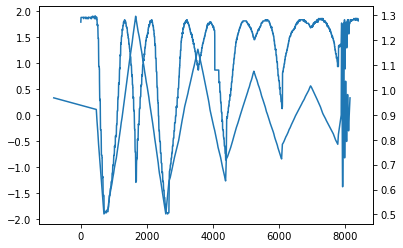

In [3]:
fig,ax = plt.subplots()
ax.plot(*current)
ax2 = ax.twinx()
ax2.plot(beam_charge[0], beam_charge_smooth)

(698, 2)


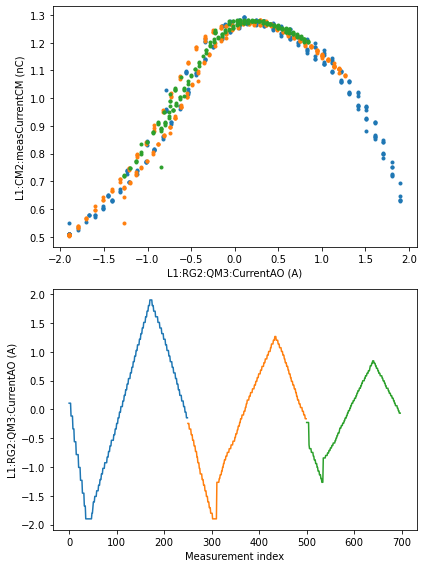

In [17]:

# bin measured current based on timestamps for current read back
end_idx = -200
timestamps = current[0][1:end_idx]
currents = current[1][1:end_idx]
beam_charge_binned = []
for i in range(len(timestamps)-1):
    beam_charge_binned += [beam_charge_smooth[np.argwhere(
        (beam_charge[0] > timestamps[i]) & (beam_charge[0] < timestamps[i+1])
    )]]

skip = 10
beam_charge_full = []
for i in range(len(currents)-1):
    for ele in beam_charge_binned[i]:
        beam_charge_full += [[currents[i], ele]]
beam_charge_full = np.asfarray(beam_charge_full)[::skip]
print(beam_charge_full.shape)

# indices to sep cycles
cycle_indicies = np.array([0, 250, 500, len(beam_charge_full)]) * 10/skip
cycle_indicies = cycle_indicies.astype('int')

fig, (ax, ax2) = plt.subplots(2,1)
fig.set_size_inches(6,8)
step = np.arange(len(beam_charge_full))

ax.set_xlabel('L1:RG2:QM3:CurrentAO (A)')
ax.set_ylabel('L1:CM2:measCurrentCM (nC)')

ax2.set_xlabel('Measurement index')
ax2.set_ylabel('L1:RG2:QM3:CurrentAO (A)')
for i in range(len(cycle_indicies) - 1):
    ax.plot(*beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T,
            '.', c=f'C{i}')

    ax2.plot(step[cycle_indicies[i]:cycle_indicies[i+1]],
        beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T[0],c=f'C{i}')
fig.tight_layout()
fig.savefig('experiment_data.png', dpi=300)

(229,)


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

<ErrorbarContainer object of 3 artists>

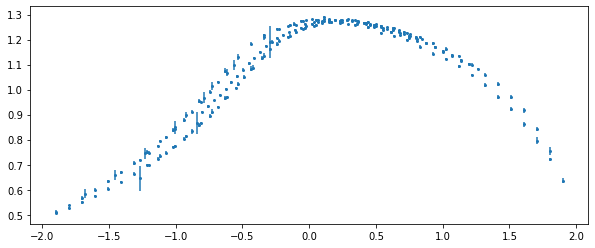

In [5]:
beam_charge_mean = np.array([np.mean(ele) for ele in beam_charge_binned])
beam_charge_std = np.array([np.std(ele) for ele in beam_charge_binned])
print(currents.shape)

fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.errorbar(currents[:-1], beam_charge_mean, beam_charge_std,fmt='o', ms=2)

In [6]:
from gpytorch import ExactMarginalLogLikelihood
from hysteresis.hybrid import ExactHybridGP
from hysteresis.base import BaseHysteresis
import torch

# clean up data that has nans - (measurements not taken during timestep)
#train_y = beam_charge_mean[np.argwhere(~np.isnan(beam_charge_mean))]
#train_x = currents[:-1][np.argwhere(~np.isnan(beam_charge_mean))]

train_x = beam_charge_full[:,0]
train_y = beam_charge_full[:,1]

# set up training data for joint hysteresis model
train_x = torch.tensor(train_x).double().reshape(-1,1)
train_y = torch.tensor(train_y).double()



H = BaseHysteresis(
    train_x.flatten(),
    polynomial_degree=1,
    mesh_scale=0.1,
    trainable=True
)
model = ExactHybridGP(train_x, train_y.flatten().clone(), H)
mll = ExactMarginalLogLikelihood(model.gp.likelihood, model)

In [7]:
from botorch.models import SingleTaskGP

#create normal GP model
gp = SingleTaskGP(
    train_x,
    train_y.reshape(-1,1)
)
gp_mll = ExactMarginalLogLikelihood(gp.likelihood, gp)


In [8]:
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_torch

res = fit_gpytorch_model(mll)
gp_res = fit_gpytorch_model(gp_mll)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PolyCollection at 0x26d92c80f40>)

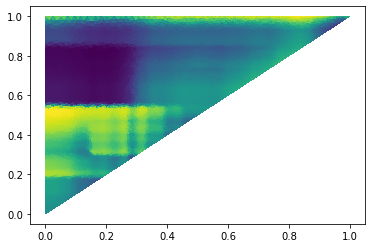

In [9]:
from hysteresis.visualization import plot_hysterion_density

plot_hysterion_density(model.hysteresis_models[0])


Generate plot for PRL

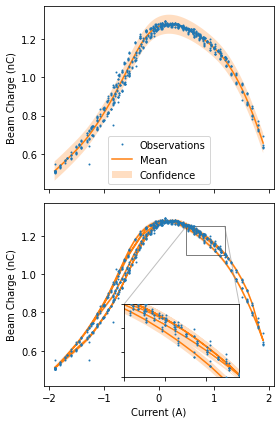

In [10]:
# compare fit to data
with torch.no_grad():
    post = model(train_x.double(), return_real=True, return_likelihood=True)
    mean_out = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()
    l = (mean_out - std).flatten()
    u = (mean_out + std).flatten()

fig, (ax2, ax) = plt.subplots(2,1,sharex='all', sharey='all')
fig.set_size_inches(4,6)
ms=1

axins = ax.inset_axes([0.35,0.05,0.5, 0.4])
axins.set_xlim(0.5,1.2)
axins.set_ylim(1.1, 1.25)
axins.set_yticklabels([])
axins.set_xticklabels([])
for a in [ax, axins]:
    a.plot(train_x, train_y, 'o',ms=ms,zorder=10)
    a.plot(train_x, mean_out.detach())
    a.fill_between(train_x.flatten(), l, u, alpha=0.25,fc='C1')
ax.indicate_inset_zoom(axins,ec='black')

test_x = torch.linspace(*model.hysteresis_models[0].valid_domain,100).double()
with torch.no_grad():
    gp_post = gp.likelihood(gp(test_x))
    gp_mean = gp_post.mean
    gp_l, gp_u = gp_post.confidence_region()

ax2.plot(train_x, train_y, 'o',ms=ms,label='Observations',zorder=10)
ax2.plot(test_x, gp_mean,label='Mean')
ax2.fill_between(test_x, gp_l, gp_u, alpha=0.25,fc='C1',label='Confidence')
ax2.legend()

ax.set_xlabel('Current (A)')
ax.set_ylabel('Beam Charge (nC)')
ax2.set_ylabel('Beam Charge (nC)')
fig.tight_layout()
#fig.savefig('experimental_modeling.png', dpi=300)

Generate plot for presentations

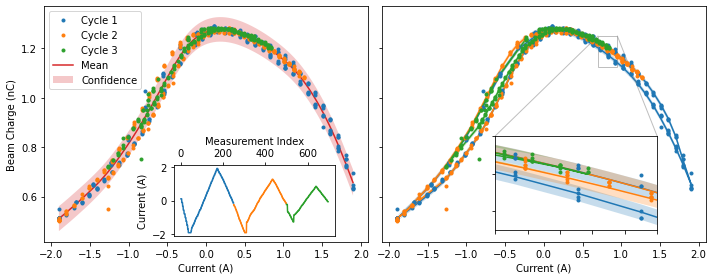

In [11]:
# compare fit to data
with torch.no_grad():
    post = model(train_x.double(), return_real=True, return_likelihood=True)
    mean_out = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()
    l = (mean_out - std).flatten()
    u = (mean_out + std).flatten()

fig, (ax2, ax) = plt.subplots(1,2,sharex='all', sharey='all')
fig.set_size_inches(10,4)
ms=3


axins = ax.inset_axes([0.35,0.05,0.5, 0.4])
#axins.set_xlim(0.45,0.6)
#axins.set_ylim(1.225, 1.275)

axins.set_xlim(0.7,0.95)
axins.set_ylim(1.125, 1.25)

axins.set_yticklabels([])
axins.set_xticklabels([])

# plot training data
for a in [ax, axins, ax2]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(train_x[cycle_indicies[i]:cycle_indicies[i+1]],
               train_y[cycle_indicies[i]:cycle_indicies[i+1]],
               'o',ms=ms,c=f'C{i}',label=f'Cycle {i+1}',zorder=5+i)



for a in [ax, axins]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(train_x[cycle_indicies[i]:cycle_indicies[i+1]],
               mean_out[cycle_indicies[i]:cycle_indicies[i+1]].detach(),
               f'C{i}')
        a.fill_between(train_x.flatten()[cycle_indicies[i]:cycle_indicies[i+1]],
                       l[cycle_indicies[i]:cycle_indicies[i+1]],
                       u[cycle_indicies[i]:cycle_indicies[i+1]],
                       alpha=0.25,fc=f'C{i}')
ax.indicate_inset_zoom(axins)

test_x = torch.linspace(*model.hysteresis_models[0].valid_domain,100).double()
with torch.no_grad():
    gp_post = gp.likelihood(gp(test_x))
    gp_mean = gp_post.mean
    gp_l, gp_u = gp_post.confidence_region()

ax2.plot(test_x, gp_mean,'C3', label='Mean')
ax2.fill_between(test_x, gp_l, gp_u, alpha=0.25,fc='C3',label='Confidence')
ax2.legend()

ax.set_xlabel('Current (A)')
ax2.set_ylabel('Beam Charge (nC)')
ax2.set_xlabel('Current (A)')
fig.tight_layout()

axins2 = ax2.inset_axes([0.4,0.025,0.5, 0.3])
axins2.set_ylabel('Current (A)')
axins2.set_xlabel('Measurement Index')
axins2.xaxis.tick_top()
axins2.xaxis.set_label_position('top')

step = np.arange(len(beam_charge_full))

for i in range(len(cycle_indicies) - 1):
    axins2.plot(step[cycle_indicies[i]:cycle_indicies[i+1]],
        beam_charge_full[cycle_indicies[i]:cycle_indicies[i+1]].T[0],c=f'C{i}')



#fig.savefig('experimental_modeling_presentation.png', dpi=300)
